In [1]:
import numpy as np
import emcee
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm 
import matplotlib.mlab as mlab
import phoebe

# from scipy.stats import norm #for python3

removing "outliers" 


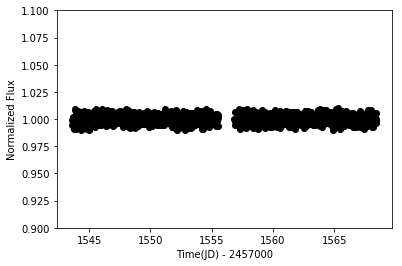

In [2]:
ID=int(335437891)
Sector=int(9)
path='/Users/felizd/Desktop/TESS/PetersEBs/Mary_data/LCs/'
data=np.transpose(np.loadtxt(path+'TIC_'+str(ID)+'.lc'))

t=data[0]
f=data[1]
e=data[2]


# plt.errorbar(t- 2457000,f,yerr=e,linestyle='none')
# plt.plot(t- 2457000,f,'ko',linestyle='none')
# plt.xlabel('Time(JD) - 2457000')
# plt.ylabel('Normalized Flux')
# plt.show()

print('removing "outliers" ')

m= np.abs(f-1.0) < 0.01

T=t[m];F=f[m];E=e[m]

plt.plot(T- 2457000,F,'ko',linestyle='none')
plt.xlabel('Time(JD) - 2457000')
plt.ylabel('Normalized Flux')
plt.ylim(0.9,1.1)
plt.show()


In [3]:
# General Steps to fitting with PHOEBE:
## 1: 

In [4]:
#making hyperparameters
nwalkers = 10
niter = 2

#Now we have our data, we need to set the hyperparamters required to run emcee. 
#Here the prior boxes provide the lower and upper limits for the phoebe parameter values. 
#We will select the order to be incl, requiv1, requiv2, mass ratio
init_dist = [(86.4,87.3),(1.15,1.25),(0.725,0.825),(0.675,0.725)]

#Here we will set uninformed priors, but you can have informed priors such as gaussian priors:
priors = [(80.,90),(1.1,1.3),(0.7,0.9),(0.6,0.9)]

injecting EB


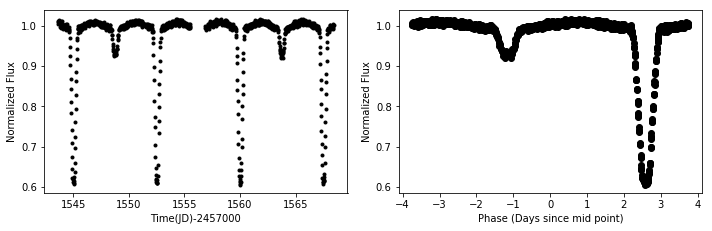

In [5]:
#make a new model to inject synthetic data
mod = phoebe.default_binary()

# mod['period@orbit'] = 5.0
# mod['sma@orbit'] = 5.0
# mod['incl@orbit'] = 90 #inclination 
# mod['requiv@primary'] = 0.5
# mod['requiv@secondary'] = 0.5
# mod['teff@primary'] = 3800.
# mod['teff@secondary'] = 3500.
mod['period@orbit'] = 7.5
mod['sma@orbit'] = 5
mod['incl@orbit'] = 90.0
mod['requiv@primary'] = 1.0
mod['teff@primary'] = 6000.
# mod['requiv@primary'] = 0.6 #equal star
# mod['teff@primary'] = 4000.
mod['requiv@secondary'] = 0.6
mod['teff@secondary'] = 4000.

passband='Cousins:I' #is there a TESS one? Doesn't look like it...

mod.add_dataset('lc', times = T, fluxes=F, sigmas=E,passband=passband) #compute_phases=np.linspace(0,1.,51), passband=passband)

#reducing parameter space to run faster 
mod.get_parameter(context='compute', qualifier='irrad_method').set_value("none")
mod.get_parameter(context='compute', component='primary', qualifier='ntriangles').set_value(300)
mod.get_parameter(context='compute', component='secondary', qualifier='ntriangles').set_value(300)

#Create Model
mod.run_compute()


model_t,model_f=mod['model@times'].value,mod['model@fluxes'].value

print('injecting EB')
injF= model_f - F+1
injF/=np.median(injF) #renormalizing (b/c Phoebe is weird?)


fig=plt.figure(figsize=(10,6))
ax1=fig.add_subplot(221)
#Light Curve
ax1.plot(T-2457000,injF,'k.')
ax1.set_ylabel('Normalized Flux')
ax1.set_xlabel('Time(JD)-2457000')

#Phase Curve
def phasefold(T0,time,period):
    return (time- T0 + 0.5*period) % period - 0.5*period   

pf=phasefold( (T[-1]-T[0])/2.0 , T, mod['period@orbit'].value )

ax2=fig.add_subplot(222)
ax2.plot(pf,injF,'ko')
ax2.set_ylabel('Normalized Flux')
ax2.set_xlabel('Phase (Days since mid point)')
plt.tight_layout()
plt.show()

# print mod.get_ephemeris(t0='t0_supconj')
# print mod.get_ephemeris(t0='t0_perpass')
# print mod.get_ephemeris(t0='t0_ref')

# print "asini: {}, sma: {}, incl: {}".format(
#     mod.get_value(qualifier='asini', component='binary', context='component'),
#     mod.get_value(qualifier='sma', component='binary', context='component'),
#     mod.get_value(qualifier='incl', component='binary', context='component'))

In [6]:
#make a new model to inject synthetic data
mod = phoebe.default_binary()

passband='Cousins:I' #is there a TESS one? Doesn't look like it...

#put injF - 1 to zero the LC (models seem to add 1 for some reason?)
mod.add_dataset('lc', times = T, fluxes=injF-1.0, sigmas=E,passband=passband) #compute_phases=np.linspace(0,1.,51), passband=passband)


#reducing parameter space to run faster 
mod.get_parameter(context='compute', qualifier='irrad_method').set_value("none")
mod.get_parameter(context='compute', component='primary', qualifier='ntriangles').set_value(300)
mod.get_parameter(context='compute', component='secondary', qualifier='ntriangles').set_value(300)

#Create Model
mod.run_compute()

<ParameterSet: 2 parameters | qualifiers: fluxes, times>

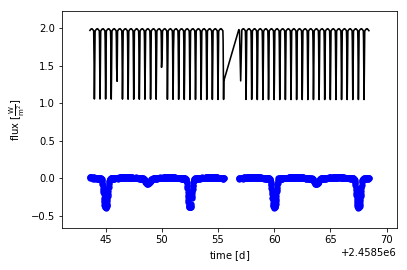

(<Figure | 1 axes | 2 call(s)>, <Figure size 432x288 with 1 Axes>)

In [7]:
mod.plot(show=True)

In [8]:
#creating initial guesses
def rpars(init_dist):
    return [np.random.rand() * (i[1]-i[0]) + i[0] for i in init_dist]

# Instate the priors such that if a parameter falls outside the prior range, 
# the value will be set to negative infinity and the model will not be accepted:
def lnprior(priors, values):
    
    lp = 0.
    for value, prior in zip(values, priors):
        if value >= prior[0] and value <= prior[1]:
            lp+=0
        else:
            lp+=-np.inf 
    return lp

#determine log probabilitiy with this function
def lnprob(z):

    mod['incl@binary@orbit@component'] = z[0]
    mod['requiv@primary@star@component'] = z[1]
    mod['requiv@secondary@star@component'] = z[2]
    mod['q@binary@orbit@component'] = z[3]
    
    lnp = lnprior(priors,z)
    if not np.isfinite(lnp):
            return -np.inf
    
    try: 
        mod.run_compute()

        # use chi^2 to compare the model to the data:
        chi2 = 0.
        for dataset in mod.get_model().datasets:
            chi2+=np.sum(mod.compute_residuals(dataset=dataset, as_quantity=False)**2/sigmas**2)
        # calculate lnprob
        lnprob = -0.5*chi2 + lnp
        return lnprob
    except:
        return -np.inf

In [9]:
#put it all together
def run(init_dist, nwalkers, niter):
    # Specify the number of dimensions for mcmc
    ndim = len(init_dist)

    # Generate initial guesses for all parameters for all chains
    p0 = np.array([rpars(init_dist) for i in xrange(nwalkers)])

    # Generate the emcee sampler. Here the inputs provided include the lnprob function. 
    # With this setup, the value z in the lnprob function#
    # is the output from the sampler.
    sampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob)
    
    #pos is the position of the walkers in parameter space
    #prob is the probability of the given "pos" positions
    #state is the state of the random number generator
    pos, prob, state = sampler.run_mcmc(p0, niter)

    for i in range(ndim):
        plt.figure()
        y = sampler.flatchain[:,i]
        n, bins, patches = plt.hist(y, 200, normed=1, color="b", alpha=0.45)#, histtype="step")
        plt.title("Dimension {0:d}".format(i))
        
        mu = np.average(y)
        sigma = np.std(y)
        
        print "mu = ", mu
        print "sigma = ",sigmas

        bf = mlab.normpdf(bins, mu, sigma)
        l = plt.plot(bins, bf, 'k--', linewidth=2.0)
        plt.xlabel('bins')
        plt.ylabel('histogram?')
    plt.show()
    return pos

/Users/felizd/anaconda2/lib/python2.7/site-packages/emcee/ensemble.py:258: RuntimeWarning: Initial state is not linearly independent and it will not allow a full exploration of parameter space
  category=RuntimeWarning,
/Users/felizd/anaconda2/lib/python2.7/site-packages/emcee/moves/red_blue.py:97: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/Users/felizd/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/felizd/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


mu =  86.93362502267412
sigma =  [0.01123394 0.01483429 0.01617319 ... 0.02998139 0.02912604 0.02922774]
mu =  1.204161945473528
sigma =  [0.01123394 0.01483429 0.01617319 ... 0.02998139 0.02912604 0.02922774]
mu =  0.7739522813623012
sigma =  [0.01123394 0.01483429 0.01617319 ... 0.02998139 0.02912604 0.02922774]
mu =  0.6979559694490642
sigma =  [0.01123394 0.01483429 0.01617319 ... 0.02998139 0.02912604 0.02922774]


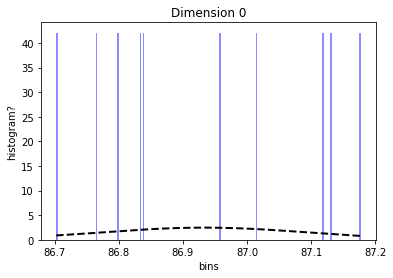

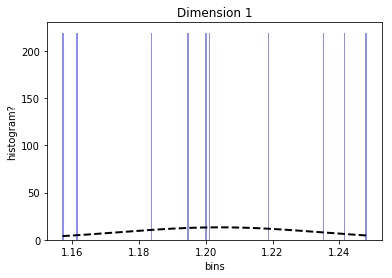

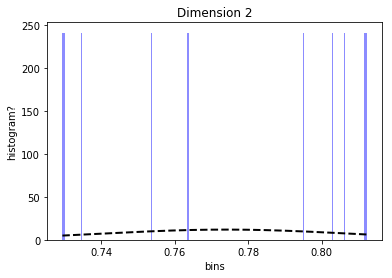

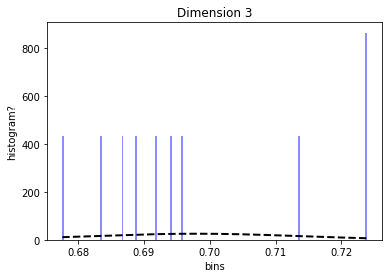

('runtime = ', 33.258859447638194, ' minutes')


In [10]:
sigmas=E
times=T
fluxes=injF

import time as tt

start=tt.time()

pos = run(init_dist, nwalkers, niter)

print('runtime = ', (tt.time()-start)/60.0,' minutes')

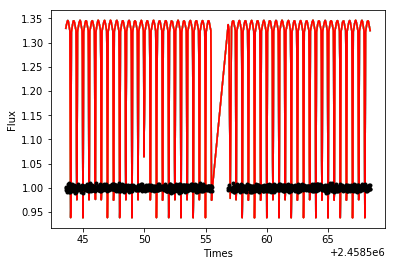

In [11]:
color=cm.rainbow(np.linspace(0,1,nwalkers))
for i,c in zip(range(nwalkers),color):
  
    #pl.figure()
    
    # Set all the parameter values
    mod['incl@binary@orbit@component'] = pos[-1-i,0] #inclination
    mod['requiv@primary@star@component'] = pos[-1-i,1] #requiv 1
    mod['requiv@secondary@star@component'] = pos[-1-i,2] #requiv 2
    mod['q@binary@orbit@component'] = pos[-1-i,3] #mass ratio primary:secondary
        
    mod.run_compute(model='run{}'.format(i))
    
    model = mod['fluxes@latest@model'].get_value()
    plt.plot(T,model,c=c)

plt.xlabel("Times")
plt.ylabel("Flux")
plt.plot(T,injF,"k.")
plt.show()    

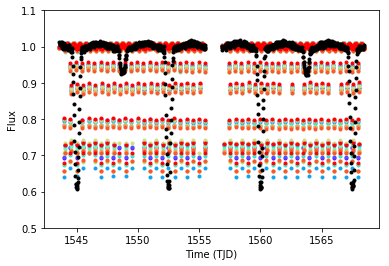

(1073, 1073, 1073)


In [13]:
for i,c in zip(range(nwalkers),color):
    #model by itself seems offset, normalizing it fixes it.
    
    f=mod['fluxes@run{}'.format(i)].interp_value(times=T)
    
    model = f
    norm_model=f/np.median(f)
#     pl.plot(T-2457000,model,c=c,marker='.',linestyle='-')
    plt.plot(T-2457000,norm_model,c=c,marker='.',linestyle='none')

plt.xlabel("Time (TJD)")
plt.ylabel("Flux")
plt.plot(T-2457000,injF,"k.")
plt.ylim(0.5,1.1)
plt.show()

print(len(T),len(model),len(F))

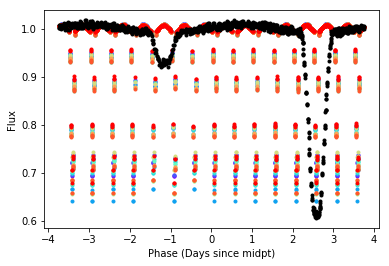

(1073, 1073, 1073)


In [20]:
pf=phasefold( (T[-1]-T[0])/2.0 , T, 7.5)

for i,c in zip(range(nwalkers),color):
    #model by itself seems offset, normalizing it fixes it.
    
    f=mod['fluxes@run{}'.format(i)].interp_value(times=T)
    
    model = f
    norm_model=f/np.median(f)
    
    plt.plot(pf,norm_model,c=c,marker='.',linestyle='none')

plt.xlabel("Phase (Days since midpt)")
plt.ylabel("Flux")
plt.plot(pf,injF,"k.")
# plt.ylim(0.5,1.1)
plt.show()

print(len(T),len(model),len(F))